In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from tqdm import tqdm
import math
import pywt

In [7]:
retina_df = pd.read_csv("../Data/Retina_DF_BalType_Binary.csv")
retina_df.sample(5)

,image,level,binary_type,binary_level
1130,15454_left,0,NO DR,0
222,10464_left,0,NO DR,0
193,11607_right,0,NO DR,0
1042,34400_left,4,DR,1
319,21521_left,0,NO DR,0


In [8]:
N = retina_df.shape[0]
imagenes_retina_mod = np.empty((N, 224, 224, 3), dtype=np.uint8)
ruta_imagenes = "../Data/Train/"
imagenes_retina = []

In [9]:
contador = 0

In [10]:
for index, path in enumerate(tqdm(retina_df['image'], desc="Cargando Imagenes: ")):
    img_aux = cv2.imread(ruta_imagenes+path+".jpeg")
    img_aux = cv2.cvtColor(img_aux, cv2.COLOR_BGR2RGB)
    img_aux = cv2.resize(img_aux,(224,224),interpolation=cv2.INTER_LANCZOS4)

    if index == 10:
        break;

    imagenes_retina.append(img_aux)

Cargando Imagenes:   1%|          | 10/1200 [00:00<01:27, 13.67it/s]


In [11]:
def mostrar_grafica(n_ren, n_col, list_image):
    fig, ax = plt.subplots(n_ren, n_col)

    for index in range(n_col*n_ren):
        #print(index//n_col, index%n_col)
        val_plot = ax[index//n_col, index%n_col]
        val_plot.axis("off")
        val_plot.imshow(list_image[index], cmap="gray")
        val_plot.title.set_text(retina_df['binary_type'][index])
        
    plt.tight_layout()
    plt.show()

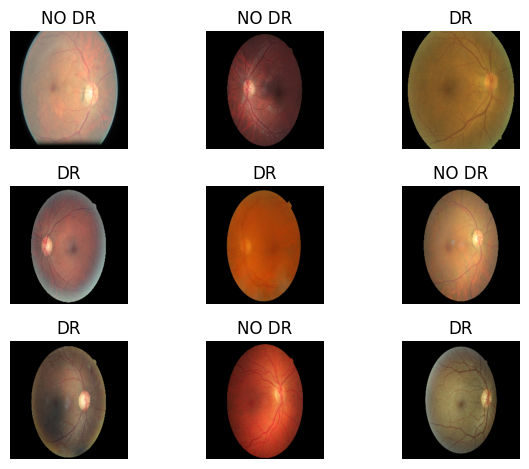

In [12]:
mostrar_grafica(n_col=3, n_ren=3, list_image=imagenes_retina)

#### PREPROCESAMIENTO

In [13]:
def ajuste_brillo_contraste(image):
    mean, stddev = cv2.meanStdDev(image)

    hist = image.flatten()
    mediana = np.percentile(hist, 50)
    ax = 128 - mediana 

    epsilon = 1e-6  

    alpha = 100 / (stddev[0][0] + epsilon)
    alpha = np.clip(alpha, 0.8, 2.5)

    beta = ax - mean[0][0]
    beta = np.clip(beta, -50, 50)

    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    return adjusted

In [14]:
def clip_limit_adaptativo(image, base_clip=2.0, scale_factor=5.0, min_limit=0.5, max_limit=2.0):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    std_dev = np.std(gray_image)
    
    normalized_std = std_dev / 255  
    clip_limit = base_clip + (normalized_std * scale_factor)

    return np.clip(clip_limit, min_limit, max_limit)

In [15]:
def clahe_funcion(image):
    clip_limit_value = clip_limit_adaptativo(image)

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_planes = list(cv2.split(lab))

    #print(clip_limit_value)
    clahe = cv2.createCLAHE(clipLimit=clip_limit_value,tileGridSize=(8,8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    return bgr

In [16]:
def recorte_Bordes(img_sinReco):
    gray_image = cv2.cvtColor(img_sinReco, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)
    contorno, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contorno:
        return cv2.resize(img_sinReco, (224, 224))

    cont = max(contorno, key=cv2.contourArea)
    
    x, y, w, h = cv2.boundingRect(cont)
    Imag_recort = img_sinReco[y:y+h, x:x+w]
    Imag_recort = cv2.resize(Imag_recort,(224,224))
    
    return Imag_recort

In [17]:
def auto_gammaCorrection(image):
    image_Gamma = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue, sat, val = cv2.split(image_Gamma)


    mid = 0.5
    mean = np.mean(val)
    meanlog = math.log(mean)
    midlog = math.log(mid*255)
    gamma = midlog/meanlog
    gamma = 1 / gamma

    table = np.array([((i / 255.0) ** gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

In [18]:
# def auto_gamma_correction(image, alpha=0.5, beta=1.5):
#     brightness = np.mean(image)

#     brightness_norm = brightness / 255.0

#     # Invertir relación: imágenes más oscuras -> gamma mayor
#     gamma = beta - (beta - alpha) * brightness_norm


#     inv_gamma = 1.0 / gamma
#     table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
#     corrected_image = cv2.LUT(image, table)

#     return corrected_image

In [19]:
def apply_wavelet_enhancement(channel, wavelet='db4', level=3, factors=(1.5, 1.5, 2.0)):
    coeffs = pywt.wavedec2(channel, wavelet, level=level)
    coeffs_H = list(coeffs)

    for i in range(1, len(coeffs_H)):
        cH, cV, cD = coeffs_H[i]
        coeffs_H[i] = (
            cH * factors[0],  # Horizontal
            cV * factors[1],  # Vertical
            cD * factors[2],  # Diagonal
        )

    enhanced_channel = pywt.waverec2(coeffs_H, wavelet)
    enhanced_channel = np.clip(enhanced_channel, 0, 255)
    return np.uint8(enhanced_channel)


In [20]:
def wavelet(imagen):
    R, G, B = cv2.split(imagen)
    R_enhanced = apply_wavelet_enhancement(R)
    G_enhanced = apply_wavelet_enhancement(G)
    B_enhanced = apply_wavelet_enhancement(B)
    
    return cv2.merge((R_enhanced, G_enhanced, B_enhanced))

In [21]:
def filtrado_bilateral(image):
    return cv2.bilateralFilter(image,9,50,50)

In [22]:
def reduccion_ruido(image):
    return cv2.fastNlMeansDenoisingColored(image, h=7, templateWindowSize=8, searchWindowSize=21)

In [23]:
for index in tqdm(range(len(imagenes_retina))):
    image_aux = imagenes_retina[index]
    # image_aux = filtrado_bilateral(image_aux)
    # image_aux = recorte_Bordes(image_aux)
    # image_aux = ajuste_brillo_contraste(image_aux)
    # image_aux = auto_gammaCorrection(image_aux)
    # image_aux = clahe_funcion(image_aux)
    # image_aux = wavelet(image_aux)
    # image_aux = recorte_Bordes(image_aux)

    #---------

    # image_aux = filtrado_bilateral(image_aux)
    # image_aux = recorte_Bordes(image_aux)
    # image_aux = ajuste_brillo_contraste(image_aux)
    # image_aux = clahe_funcion(image_aux)
    # image_aux = auto_gammaCorrection(image_aux)
    # #image_aux = wavelet(image_aux)

    image_aux = recorte_Bordes(image_aux)
    image_aux = ajuste_brillo_contraste(image_aux)
    image_aux = clahe_funcion(image_aux)
    image_aux = filtrado_bilateral(image_aux)
    image_aux = auto_gammaCorrection(image_aux)
    
    #----------
    # GUARDADO DE IMAGENES
    imagenes_retina_mod[index] = image_aux

100%|██████████| 10/10 [00:00<00:00, 36.60it/s]


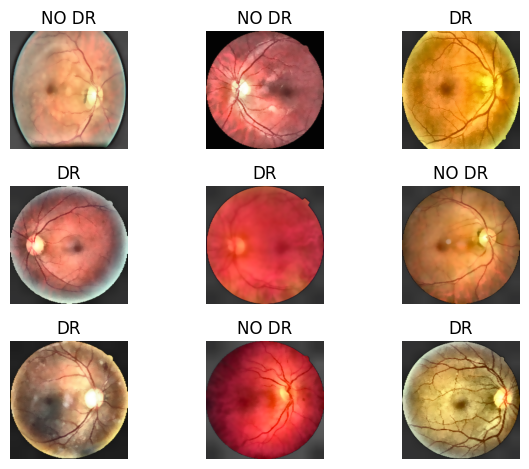

In [24]:
mostrar_grafica(n_col=3, n_ren=3, list_image=imagenes_retina_mod)

In [25]:
#mk_direccion = "../Data/Img_Preprocessing_Binary/"
#etiquetas = ["00_NO DR", "01_DR"]

In [26]:
try:
    os.mkdir("../Data/Img_Preprocessing_Binary")
    print(f" ✔️ La carpeta {"Img_Preprocessing_Binary"} se creo correctamente")
except Exception as e:
    print(f" ⚠️ Ocurrió un error inesperado: {e}")

 ⚠️ Ocurrió un error inesperado: [WinError 183] No se puede crear un archivo que ya existe: '../Data/Img_Preprocessing_Binary'


In [27]:
for index in range(len(etiquetas)):
    try:
        os.mkdir(mk_direccion+etiquetas[index])
        print(f" ✔️ La carpeta {etiquetas[index]} se creo correctamente")
    except FileExistsError:
        print(f" ❌ La carpeta {etiquetas[index]} ya existe")
    except Exception as e:
        print(f" ⚠️ Ocurrió un error inesperado: {e}")


NameError: name 'etiquetas' is not defined

In [ ]:
for index in range(len(imagenes_retina_mod)):
    try:
        tipo = etiquetas[retina_df["binary_level"][index]]
        ruta = mk_direccion+"/"+tipo+"/"+retina_df['image'][index]+".jpg"

        if os.path.exists(ruta):
            print(f" ❌ La Imagen {retina_df['image'][index]} ya existe")
            continue
        
        a1 = np.uint8(np.abs(imagenes_retina_mod[index]))
        cv2.imwrite(ruta,cv2.cvtColor(a1, cv2.COLOR_BGR2RGB))
        
    
    except Exception as e:
        print(f" ⚠️ Ocurrió un error inesperado: {e}")